In [9]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, array, random, dot
from sklearn.model_selection import train_test_split
from math import ceil

np.random.seed(1)

## Load data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).


In [2]:
train = pd.read_csv('../data/digit-recognizer/train.csv')
test = pd.read_csv('../data/digit-recognizer/test.csv')
print(f"Size of train dataset: {train.shape}")
print(f"Size of test dataset: {test.shape}")

Size of train dataset: (42000, 785)
Size of test dataset: (28000, 784)


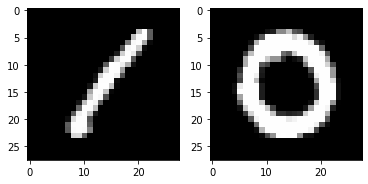

In [3]:
plt.subplot(121)
plt.imshow(np.array(train.iloc[0, 1:]).reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(np.array(train.iloc[1, 1:]).reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

## Preprocess data

Data preprocessing would include:
* Normalize the data (numeric values are rescaled in order to have values between 0 and 1)
* Split the dataset on train and validation datasets
* Represent target value as zero vector with the length equals to the number of categories and "1" value on a position corresponding to a target value, i.e. target value "4" will be threated as [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] vector. This is an important step because predicting "7" instead of real target value "8" is not better than predicting "0", both predictions are wrong

In [4]:
def vectorize_y(y):
    y_vect = np.zeros((len(y), 10))
    y_vect[list(range(len(y))), y] = 1
    return y_vect


In [5]:
test_normalized = test.values.astype('float32')
test_normalized /= 255

X = train.iloc[:, 1:].values.astype('float32')
X /= 255
y = vectorize_y(train.iloc[:, 0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)

X_train, X_test = X_train.T, X_test.T
y_train, y_test = y_train.T, y_test.T
test_normalized = test_normalized.T


## Build a model


THE LEARNING ALGORITHM
1. Initialize weights and biases randomly
2. Iterate over the data<br>
    i. Compute the output of neural network using sigmoid function for hidden layers and softmax function for output layer<br>
    ii. Compute the loss using the square error loss function<br>
    iii. W(new) = W(old) — α ∆W<br>
    iv. B(new) = B(old) — α ∆B<br>
3. Repeat in order to get minimal error

In [7]:
class DigitRecognitionNN():
    def __init__(self, structure, epochs=3, learning_rate=0.01, momentum=0.9, mini_batch_size=16):
        self.structure = structure
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.mini_batch_size = mini_batch_size
        self.cost = []
        self.params = self.initialize()

    def initialize(self):
        params = {}
        for i in range(1, len(self.structure)):
            params[f'W{i}'] = np.random.randn(self.structure[i], self.structure[i-1]) * np.sqrt(1./self.structure[i-1])
            params[f'b{i}'] = np.zeros((self.structure[i], 1))
            print(f"Initialized {i} layer: weights {params[f'W{i}'].shape}, biases {params[f'b{i}'].shape}")
        return params

    def sigmoid(self, x, derivative=False):
        sigmoid = 1./(1. + np.exp(-x))
        if derivative:
            return sigmoid * (1 - sigmoid)
        return sigmoid

    def relu(self, x, derivative=False):
        if derivative:
            x[x<=0] = 0
            x[x>0] = 1
        return np.maximum(0,x)

    def softmax(self, x, derivative=False):
        e = np.exp(x)
        softmax = e/np.sum(e, axis=0)
        if derivative:
            softmax = softmax.reshape(-1,1)
            return np.diagflat(softmax) - np.dot(softmax, softmax.T)
        return softmax

    def forward_pass(self, x_train):
        self.params['A0'] = x_train
        for i in range(1, len(self.structure)):
            self.params[f'Z{i}'] = np.dot(self.params[f'W{i}'], self.params[f'A{i-1}'])
            self.params[f'Z{i}'] += self.params[f'b{i}']
            self.params[f'A{i}'] = self.sigmoid(self.params[f'Z{i}'])
        last_layer = len(self.structure)-1
        self.params[f'A{last_layer}'] = self.softmax(self.params[f'Z{last_layer}'])
        return self.params[f'A{last_layer}']
        
    def backward_pass(self, x_train, y_train):
        gradients = {}
        last_gradient_index = len(self.structure)-1
        delta =  self.params[f'A{last_gradient_index}'] - y_train
        gradients[f'W{last_gradient_index}'] = np.dot(delta, self.params[f'A{last_gradient_index-1}'].T)
        gradients[f'b{last_gradient_index}'] = np.sum(delta, axis=1, keepdims=True)
        for i in range(len(self.structure)-2, 0, -1):
            delta = np.dot(self.params[f'W{i+1}'].T, delta) * self.sigmoid(self.params[f'Z{i}'], derivative=True)
            gradients[f'W{i}'] = (1. / self.mini_batch_size) * np.dot(delta, self.params[f'A{i-1}'].T)
            gradients[f'b{i}'] = (1. / self.mini_batch_size) * np.sum(delta, axis=1, keepdims=True)
        return gradients

    def compute_accuracy(self, X, Y):
        predictions = []
        output = self.forward_pass(X)
        pred = np.argmax(output, axis=0)
        total = sum(pred == np.argmax(Y, axis=0))
        return total/len(pred)

    def train(self, x_train, y_train, x_val, y_val):
        """Train the neural network using mini-batch stochastic gradient descent"""
        n = X_train.shape[1]
        start_time = time.time()
        delta = {}
        for i in range(1, len(self.structure)):
            delta[f'W{i}'] = np.zeros((self.structure[i], self.structure[i-1]))
            delta[f'b{i}'] = np.zeros((self.structure[i], 1))
        for epoch in range(self.epochs):
            shuffle_index = np.random.permutation(n)
            training_data_x = x_train[:, shuffle_index]
            training_data_y = y_train[:, shuffle_index]
            for i in range(ceil(self.structure[0]/self.mini_batch_size)):
                begin = epoch * self.mini_batch_size
                end = min(begin + self.mini_batch_size, x_train.shape[1] - 1)
                X = training_data_x[:, begin:end]
                Y = training_data_y[:, begin:end]
                self.forward_pass(X)
                gradients = self.backward_pass(X, Y)
                for k in range(1, len(self.structure)):
                    delta_W = -self.learning_rate * gradients[f'W{k}'] #+ self.momentum * delta[f'W{k}']
                    delta_b = -self.learning_rate * gradients[f'b{k}'] #+ self.momentum * delta[f'b{k}']
#                     delta[f'W{k}'] = delta_W
#                     delta[f'b{k}'] = delta_b
                    self.params[f'W{k}'] += delta_W
                    self.params[f'b{k}'] += delta_b
            train_accuracy = self.compute_accuracy(x_train, y_train)
            test_accuracy = self.compute_accuracy(x_val, y_val)
            print("Epoch {}. Time spent: {:.2f}. Accuracy on train set: {:.2f}%. Accuracy on test set: {:.2f}%.".format(
                epoch+1, time.time() - start_time, train_accuracy*100, test_accuracy*100))
        print("Finished.")

In [10]:
# nn_structure = [784, 128, 64, 10]
# nn_structure = [784, 350, 10]
# nn_structure = [784, 512, 512, 10]
nn_structure = [784, 64, 10]
epochs = 50
learning_rate = 0.4
momentum = 0.9
mini_batch_size = 64
print(f"Setting epochs to {epochs}")
print(f"Setting learn rate to {learning_rate}")
print(f"Setting momentum to {momentum}")
print(f"Setting batch size to {mini_batch_size}")
# key tips:
# 1) activation function, which one works better
# 2) run with small and big learning rates
# 3) number of layers, number of neurons, batch size
# 4) try to wait for more epochs
drnn = DigitRecognitionNN(nn_structure, epochs=epochs, learning_rate=learning_rate, 
                          momentum=momentum, mini_batch_size=mini_batch_size)
drnn.train(X_train, y_train, X_test, y_test)

Setting epochs to 50
Setting learn rate to 0.4
Setting momentum to 0.9
Setting batch size to 64
Initialized 1 layer: weights (64, 784), biases (64, 1)
Initialized 2 layer: weights (10, 64), biases (10, 1)
Epoch 1. Time spent: 2.02. Accuracy on train set: 10.02%. Accuracy on test set: 10.98%.
Epoch 2. Time spent: 3.58. Accuracy on train set: 10.17%. Accuracy on test set: 9.36%.
Epoch 3. Time spent: 4.78. Accuracy on train set: 24.33%. Accuracy on test set: 24.43%.
Epoch 4. Time spent: 6.06. Accuracy on train set: 24.78%. Accuracy on test set: 25.40%.
Epoch 5. Time spent: 7.20. Accuracy on train set: 19.83%. Accuracy on test set: 20.21%.
Epoch 6. Time spent: 8.31. Accuracy on train set: 39.38%. Accuracy on test set: 39.71%.
Epoch 7. Time spent: 9.42. Accuracy on train set: 49.18%. Accuracy on test set: 49.79%.
Epoch 8. Time spent: 10.51. Accuracy on train set: 57.89%. Accuracy on test set: 58.19%.
Epoch 9. Time spent: 11.58. Accuracy on train set: 58.75%. Accuracy on test set: 59.74%.
Ep

## Submit the prediction

In [11]:
prediction = []
output = drnn.forward_pass(test_normalized)
prediction = np.argmax(output, axis=0)
submission = pd.DataFrame({
    "ImageId": list(range(1, test.shape[0]+1)),
    "Label": prediction
})
submission.to_csv("../data/digit-recognizer/digit-recognizer-submission.csv", index=False)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,2
